## Setup and speed
enable xla mixed precision and gpu memory growth

In [12]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'
import json, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

tf.config.optimizer.set_jit(True)
try: tf.config.experimental.enable_tensor_float_32_execution(True)
except: pass
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except: pass


## Load meta and data
use balanced train and raw val

In [13]:
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)
num_classes = len(meta['label_classes'])

x_train_path = '../artifacts/X_train_balanced.npy' if os.path.exists('../artifacts/X_train_balanced.npy') else '../artifacts/X_train.npy'
y_train_path = '../artifacts/y_train_balanced.npy' if os.path.exists('../artifacts/y_train_balanced.npy') else '../artifacts/y_train.npy'

X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_val   = np.load('../artifacts/X_val.npy')
y_val   = np.load('../artifacts/y_val.npy')

y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val,   num_classes)

# one hot inputs are binary so no scaling


## Make tf datasets
cast to float16 and build input pipeline

In [14]:
X_train = X_train.astype('float16', copy=False)
X_val   = X_val.astype('float16', copy=False)

BATCH = 1024
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh)).cache().shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_oh)).cache().batch(BATCH).prefetch(tf.data.AUTOTUNE)

os.makedirs('../artifacts/experiments', exist_ok=True)


# Define experiment configs
relu tanh sigmoid with and without dropout with different sizes

In [15]:
configs = [
    # relu no dropout
    {'name':'relu_1x64_do0',      'layers':[64],                  'act':'relu',    'dropout':0.0},
    {'name':'relu_2x128_do0',     'layers':[128,128],             'act':'relu',    'dropout':0.0},
    {'name':'relu_3x256_do0',     'layers':[256,256,256],         'act':'relu',    'dropout':0.0},

    # relu with dropout
    {'name':'relu_1x128_do02',    'layers':[128],                 'act':'relu',    'dropout':0.2},
    {'name':'relu_2x256_do02',    'layers':[256,256],             'act':'relu',    'dropout':0.2},
    {'name':'relu_3x256_do03',    'layers':[256,256,256],         'act':'relu',    'dropout':0.3},

    # tanh no dropout
    {'name':'tanh_1x128_do0',     'layers':[128],                 'act':'tanh',    'dropout':0.0},
    {'name':'tanh_2x128_do0',     'layers':[128,128],             'act':'tanh',    'dropout':0.0},

    # tanh with dropout
    {'name':'tanh_1x256_do02',    'layers':[256],                 'act':'tanh',    'dropout':0.2},
    {'name':'tanh_2x256_do02',    'layers':[256,256],             'act':'tanh',    'dropout':0.2},

    # sigmoid no dropout
    {'name':'sigmoid_1x128_do0',  'layers':[128],                 'act':'sigmoid', 'dropout':0.0},
    {'name':'sigmoid_2x128_do0',  'layers':[128,128],             'act':'sigmoid', 'dropout':0.0},

    # sigmoid with dropout
    {'name':'sigmoid_1x256_do02', 'layers':[256],                 'act':'sigmoid', 'dropout':0.2},
    {'name':'sigmoid_2x256_do03', 'layers':[256,256],             'act':'sigmoid', 'dropout':0.3},
]


## Model builder
simple dense net factory from a config

In [16]:
def build_model(input_dim, cfg, num_classes):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for u in cfg['layers']:
        x = keras.layers.Dense(u, activation=cfg['act'])(x)
        if cfg['dropout'] > 0.0:
            x = keras.layers.Dropout(cfg['dropout'])(x)
    out = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    m = keras.Model(inp, out)
    opt = keras.optimizers.legacy.Adam(1e-3)
    m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return m


# Run experiments
train each config save plots reports collect histories and confusion matrices

[1/14] relu_1x64_do0
Epoch 1/20
20/20 [==============================] - 1s 18ms/step - loss: 2.2566 - accuracy: 0.1834 - val_loss: 2.2634 - val_accuracy: 0.1552
Epoch 2/20
20/20 [==============================] - 0s 23ms/step - loss: 2.0478 - accuracy: 0.3446 - val_loss: 2.1796 - val_accuracy: 0.1978
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 1.8588 - accuracy: 0.4313 - val_loss: 2.0805 - val_accuracy: 0.2322
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 1.6839 - accuracy: 0.4795 - val_loss: 1.9856 - val_accuracy: 0.2475
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.5266 - accuracy: 0.5233 - val_loss: 1.8852 - val_accuracy: 0.2693
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.3905 - accuracy: 0.5630 - val_loss: 1.8071 - val_accuracy: 0.2894
Epoch 7/20
20/20 [==============================] - 0s 11ms/step - loss: 1.2773 - accuracy: 0.5947 - val_loss: 1.7252 - val_accuracy: 0.

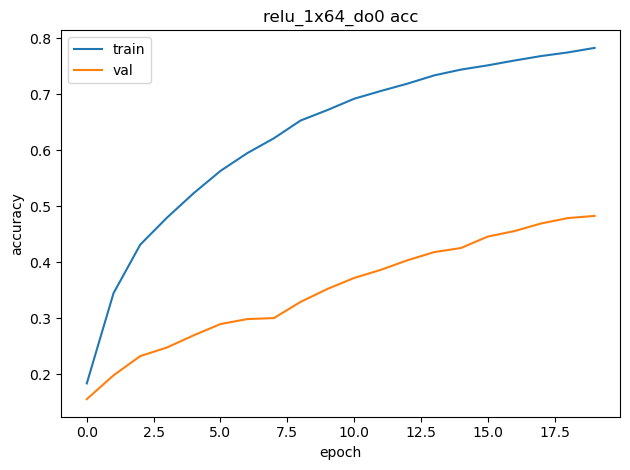

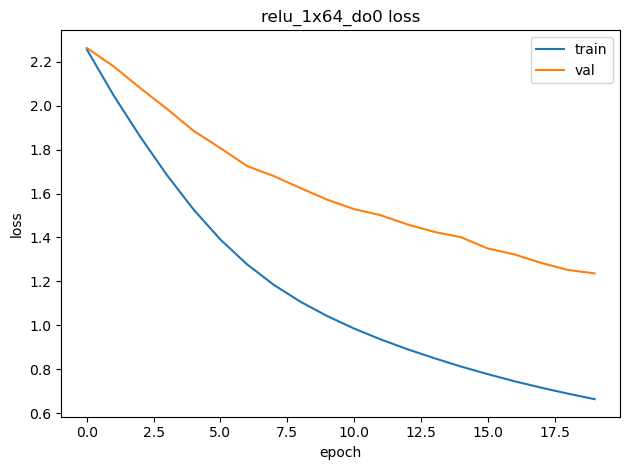

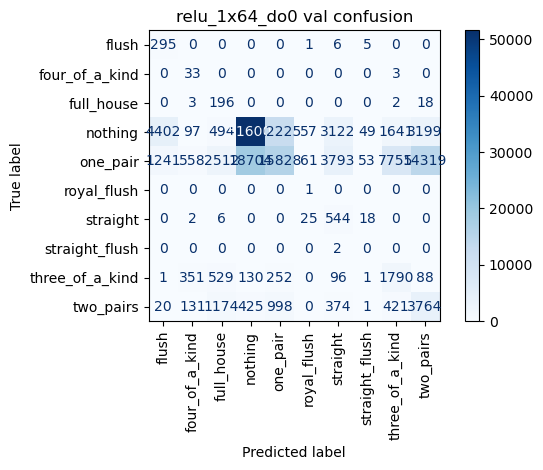

[2/14] relu_2x128_do0
Epoch 1/20
20/20 [==============================] - 1s 18ms/step - loss: 2.1143 - accuracy: 0.2911 - val_loss: 2.2142 - val_accuracy: 0.1026
Epoch 2/20
20/20 [==============================] - 1s 36ms/step - loss: 1.6826 - accuracy: 0.4773 - val_loss: 1.9325 - val_accuracy: 0.2159
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 1.2762 - accuracy: 0.5872 - val_loss: 1.6573 - val_accuracy: 0.3128
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 0.9621 - accuracy: 0.6798 - val_loss: 1.4421 - val_accuracy: 0.3998
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 0.7634 - accuracy: 0.7394 - val_loss: 1.2491 - val_accuracy: 0.4693
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.6387 - accuracy: 0.7739 - val_loss: 1.1656 - val_accuracy: 0.4939
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 0.5556 - accuracy: 0.8013 - val_loss: 1.0698 - val_accuracy: 0.

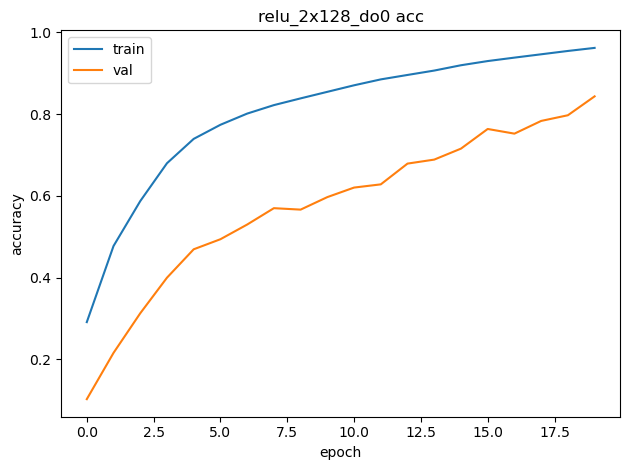

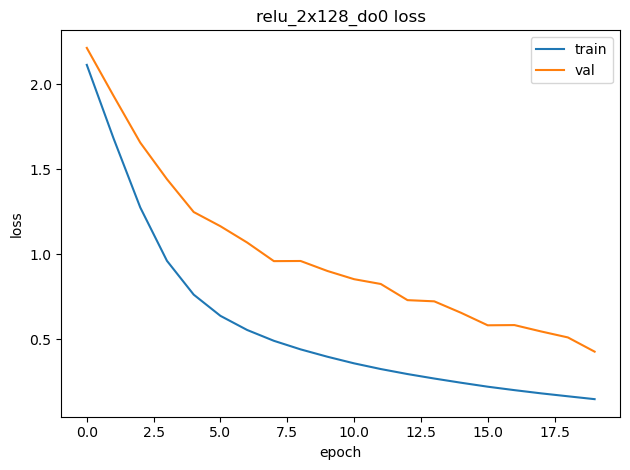

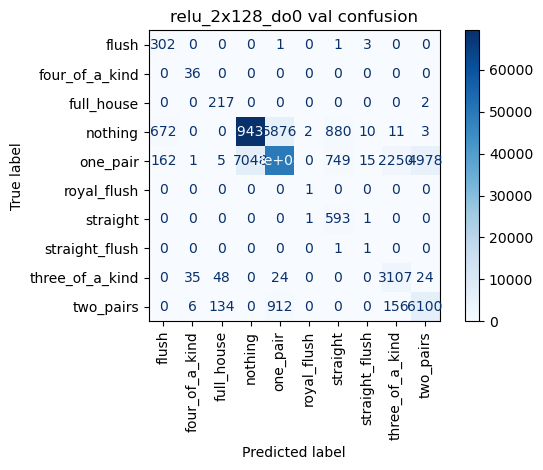

[3/14] relu_3x256_do0
Epoch 1/20
20/20 [==============================] - 1s 22ms/step - loss: 1.8875 - accuracy: 0.4182 - val_loss: 1.8279 - val_accuracy: 0.2908
Epoch 2/20
20/20 [==============================] - 1s 33ms/step - loss: 1.0134 - accuracy: 0.6475 - val_loss: 1.2245 - val_accuracy: 0.4788
Epoch 3/20
20/20 [==============================] - 0s 11ms/step - loss: 0.6181 - accuracy: 0.7736 - val_loss: 1.0232 - val_accuracy: 0.5465
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 0.4420 - accuracy: 0.8340 - val_loss: 0.9118 - val_accuracy: 0.5859
Epoch 5/20
20/20 [==============================] - 0s 12ms/step - loss: 0.3294 - accuracy: 0.8806 - val_loss: 0.7629 - val_accuracy: 0.6531
Epoch 6/20
20/20 [==============================] - 0s 10ms/step - loss: 0.2507 - accuracy: 0.9110 - val_loss: 0.5588 - val_accuracy: 0.7767
Epoch 7/20
20/20 [==============================] - 0s 11ms/step - loss: 0.1867 - accuracy: 0.9396 - val_loss: 0.4375 - val_accuracy

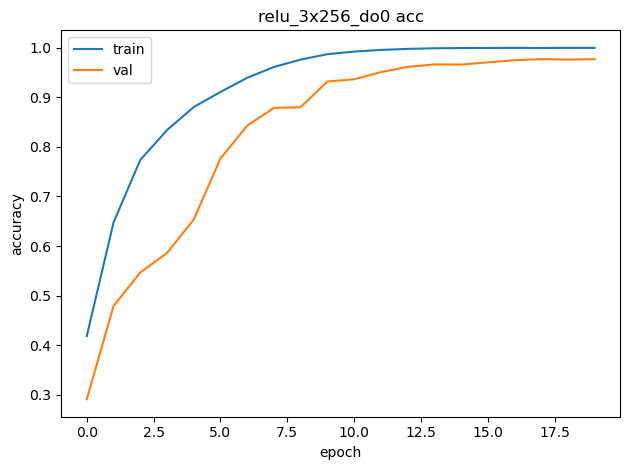

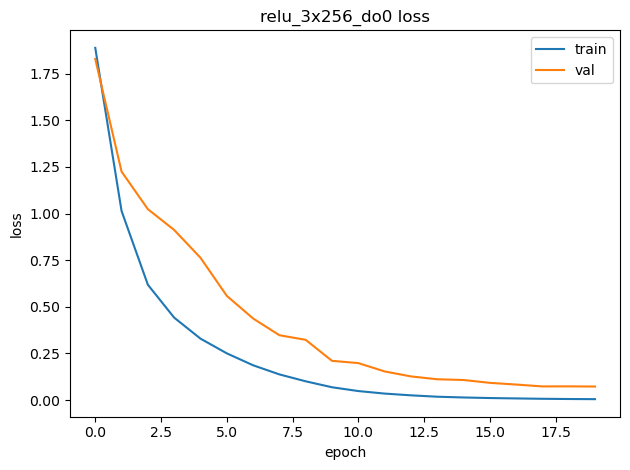

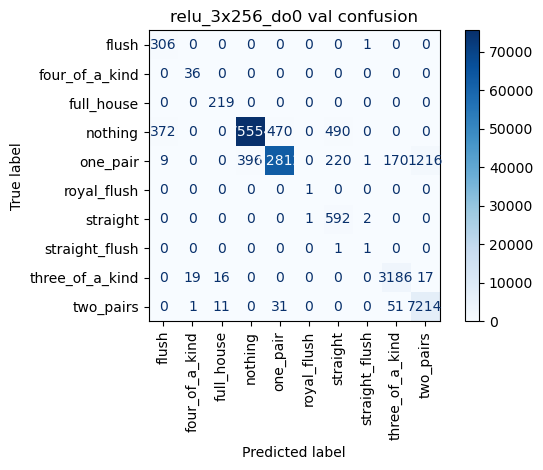

[4/14] relu_1x128_do02
Epoch 1/20
20/20 [==============================] - 1s 18ms/step - loss: 2.1720 - accuracy: 0.2549 - val_loss: 2.2127 - val_accuracy: 0.1549
Epoch 2/20
20/20 [==============================] - 0s 24ms/step - loss: 1.8963 - accuracy: 0.4281 - val_loss: 2.0587 - val_accuracy: 0.2355
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 1.6542 - accuracy: 0.4927 - val_loss: 1.9142 - val_accuracy: 0.2853
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.4556 - accuracy: 0.5386 - val_loss: 1.7963 - val_accuracy: 0.3238
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2999 - accuracy: 0.5772 - val_loss: 1.7027 - val_accuracy: 0.3417
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1755 - accuracy: 0.6113 - val_loss: 1.6123 - val_accuracy: 0.3831
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.0779 - accuracy: 0.6481 - val_loss: 1.5579 - val_accuracy: 0.

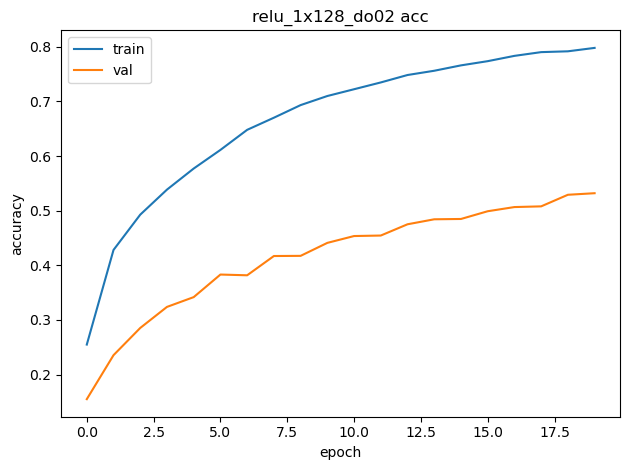

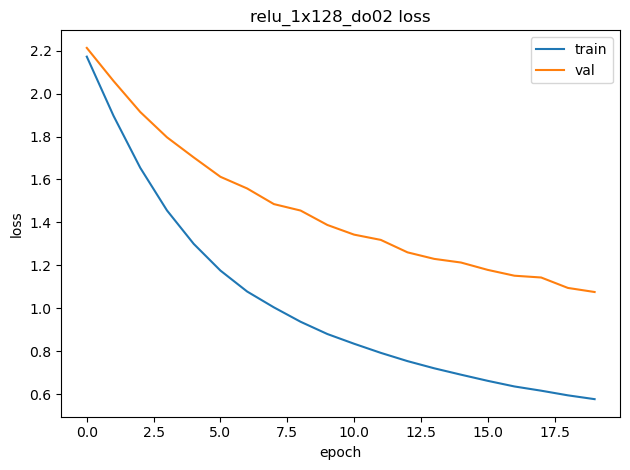

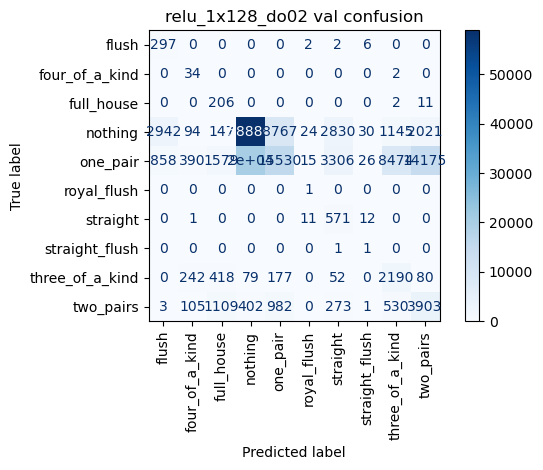

[5/14] relu_2x256_do02
Epoch 1/20
20/20 [==============================] - 1s 19ms/step - loss: 1.9834 - accuracy: 0.3660 - val_loss: 2.0227 - val_accuracy: 0.2504
Epoch 2/20
20/20 [==============================] - 1s 29ms/step - loss: 1.3400 - accuracy: 0.5469 - val_loss: 1.5555 - val_accuracy: 0.3823
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.9683 - accuracy: 0.6543 - val_loss: 1.3625 - val_accuracy: 0.4412
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 0.7627 - accuracy: 0.7247 - val_loss: 1.2305 - val_accuracy: 0.4668
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 0.6420 - accuracy: 0.7650 - val_loss: 1.0771 - val_accuracy: 0.5352
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.5585 - accuracy: 0.7933 - val_loss: 1.0015 - val_accuracy: 0.5575
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 0.4914 - accuracy: 0.8148 - val_loss: 0.9404 - val_accuracy: 0.

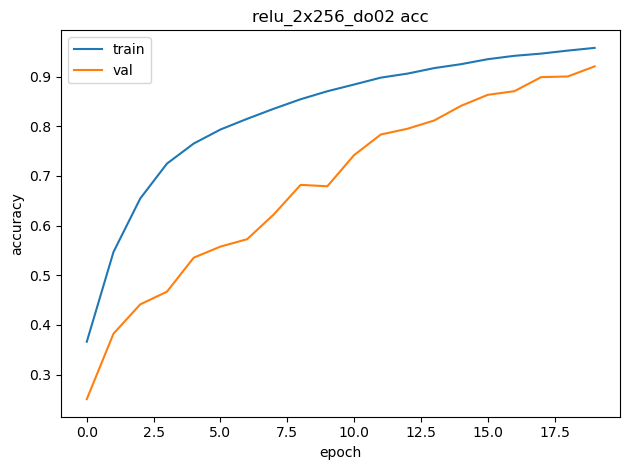

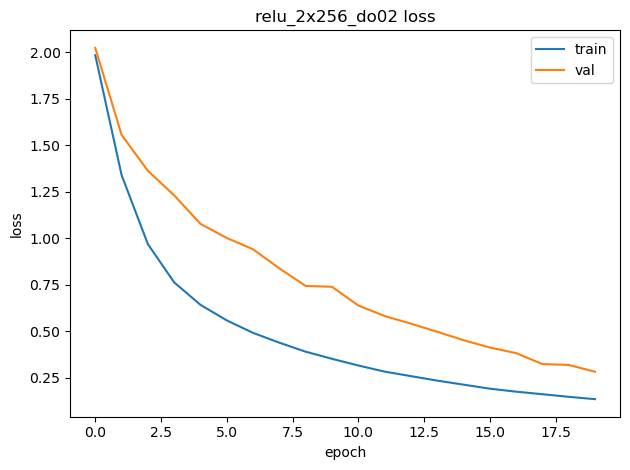

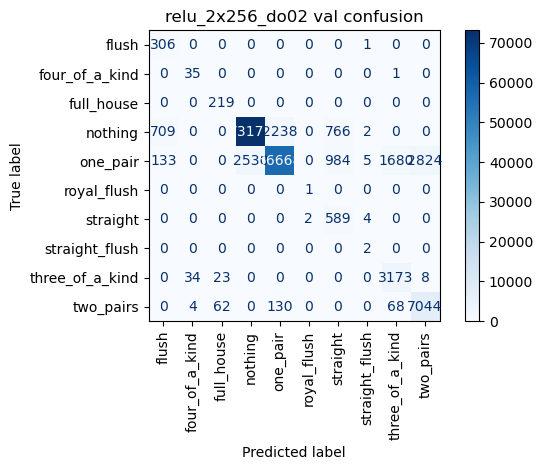

[6/14] relu_3x256_do03
Epoch 1/20
20/20 [==============================] - 1s 21ms/step - loss: 2.0190 - accuracy: 0.3144 - val_loss: 2.0072 - val_accuracy: 0.2927
Epoch 2/20
20/20 [==============================] - 1s 35ms/step - loss: 1.3286 - accuracy: 0.5170 - val_loss: 1.5787 - val_accuracy: 0.3629
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 0.9377 - accuracy: 0.6511 - val_loss: 1.2189 - val_accuracy: 0.4892
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.7408 - accuracy: 0.7148 - val_loss: 1.1088 - val_accuracy: 0.5130
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 0.6217 - accuracy: 0.7585 - val_loss: 0.9727 - val_accuracy: 0.5644
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.5408 - accuracy: 0.7857 - val_loss: 0.8676 - val_accuracy: 0.6031
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.4755 - accuracy: 0.8110 - val_loss: 0.8109 - val_accuracy: 0.

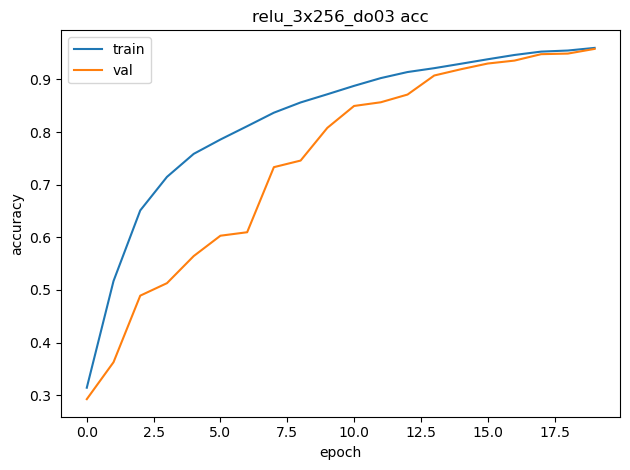

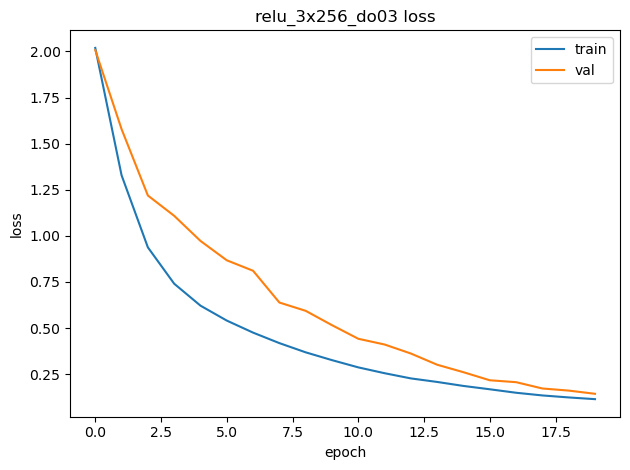

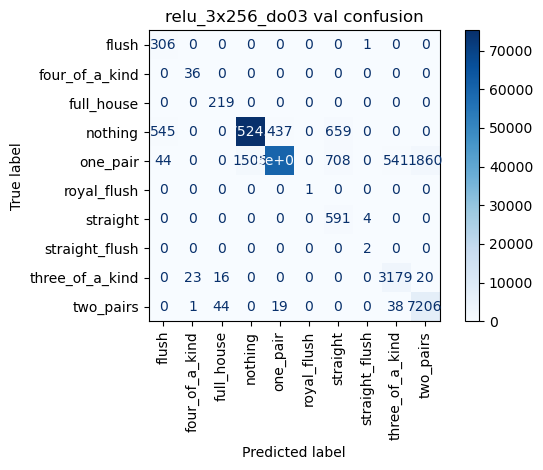

[7/14] tanh_1x128_do0
Epoch 1/20
20/20 [==============================] - 1s 19ms/step - loss: 2.1249 - accuracy: 0.2515 - val_loss: 2.1664 - val_accuracy: 0.1516
Epoch 2/20
20/20 [==============================] - 0s 22ms/step - loss: 1.7800 - accuracy: 0.4260 - val_loss: 1.9808 - val_accuracy: 0.2133
Epoch 3/20
20/20 [==============================] - 0s 12ms/step - loss: 1.5600 - accuracy: 0.4850 - val_loss: 1.8719 - val_accuracy: 0.2098
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.4086 - accuracy: 0.5216 - val_loss: 1.7862 - val_accuracy: 0.2247
Epoch 5/20
20/20 [==============================] - 0s 11ms/step - loss: 1.3027 - accuracy: 0.5477 - val_loss: 1.7026 - val_accuracy: 0.2787
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2268 - accuracy: 0.5622 - val_loss: 1.6715 - val_accuracy: 0.2710
Epoch 7/20
20/20 [==============================] - 0s 12ms/step - loss: 1.1699 - accuracy: 0.5757 - val_loss: 1.6259 - val_accuracy: 

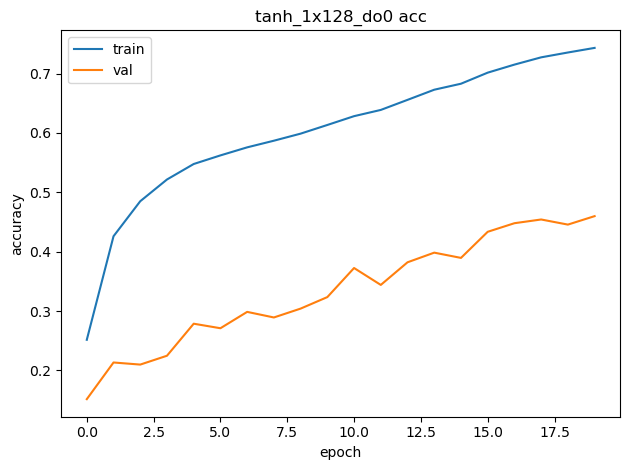

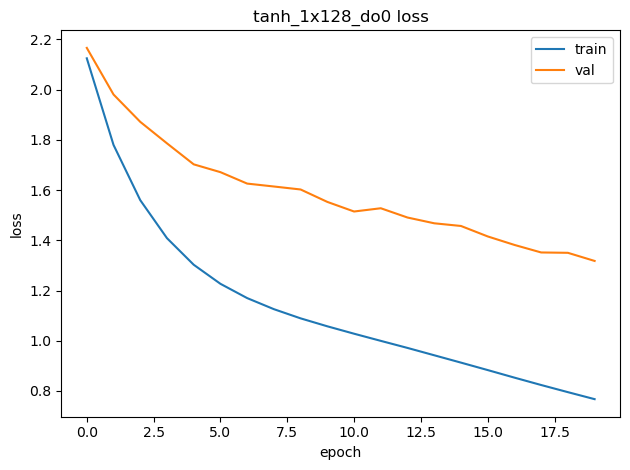

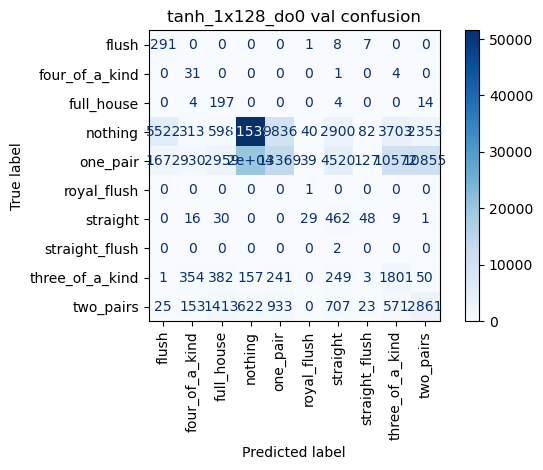

[8/14] tanh_2x128_do0
Epoch 1/20
20/20 [==============================] - 1s 21ms/step - loss: 1.9488 - accuracy: 0.3220 - val_loss: 1.9714 - val_accuracy: 0.2378
Epoch 2/20
20/20 [==============================] - 1s 30ms/step - loss: 1.4677 - accuracy: 0.4879 - val_loss: 1.7681 - val_accuracy: 0.2400
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2388 - accuracy: 0.5515 - val_loss: 1.6553 - val_accuracy: 0.3247
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1220 - accuracy: 0.5861 - val_loss: 1.5976 - val_accuracy: 0.3171
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.0493 - accuracy: 0.6158 - val_loss: 1.5356 - val_accuracy: 0.3871
Epoch 6/20
20/20 [==============================] - 0s 13ms/step - loss: 0.9855 - accuracy: 0.6428 - val_loss: 1.5017 - val_accuracy: 0.3648
Epoch 7/20
20/20 [==============================] - 0s 10ms/step - loss: 0.9197 - accuracy: 0.6769 - val_loss: 1.4754 - val_accuracy: 0

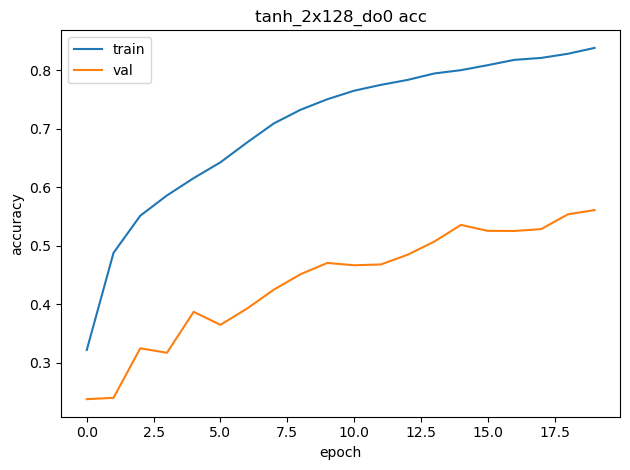

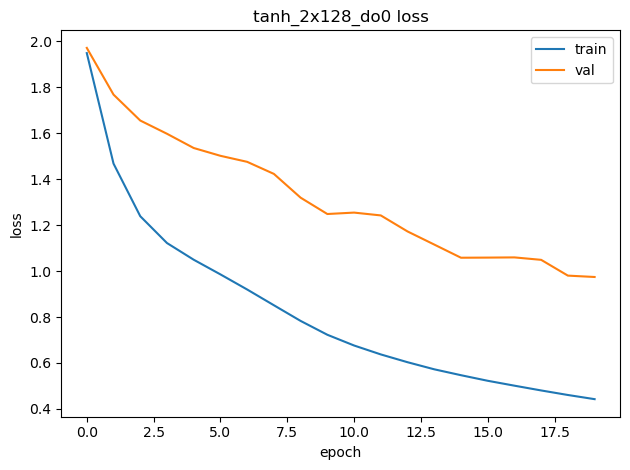

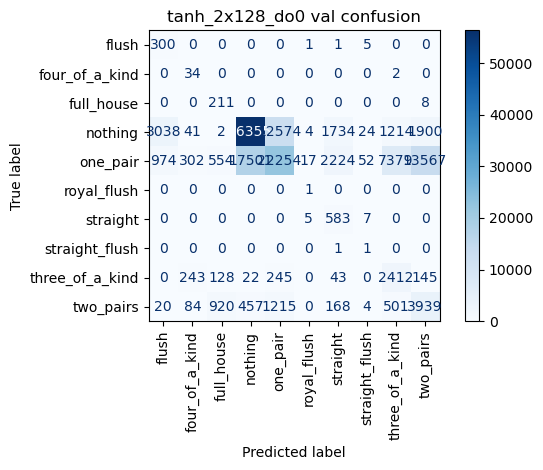

[9/14] tanh_1x256_do02
Epoch 1/20
20/20 [==============================] - 1s 17ms/step - loss: 2.0485 - accuracy: 0.3019 - val_loss: 2.1424 - val_accuracy: 0.1187
Epoch 2/20
20/20 [==============================] - 0s 23ms/step - loss: 1.6281 - accuracy: 0.4658 - val_loss: 1.9004 - val_accuracy: 0.1709
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 1.4091 - accuracy: 0.5214 - val_loss: 1.7824 - val_accuracy: 0.2150
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2812 - accuracy: 0.5429 - val_loss: 1.6701 - val_accuracy: 0.2753
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.2028 - accuracy: 0.5570 - val_loss: 1.6797 - val_accuracy: 0.2210
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1529 - accuracy: 0.5640 - val_loss: 1.6284 - val_accuracy: 0.2564
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.1148 - accuracy: 0.5777 - val_loss: 1.6022 - val_accuracy: 0.

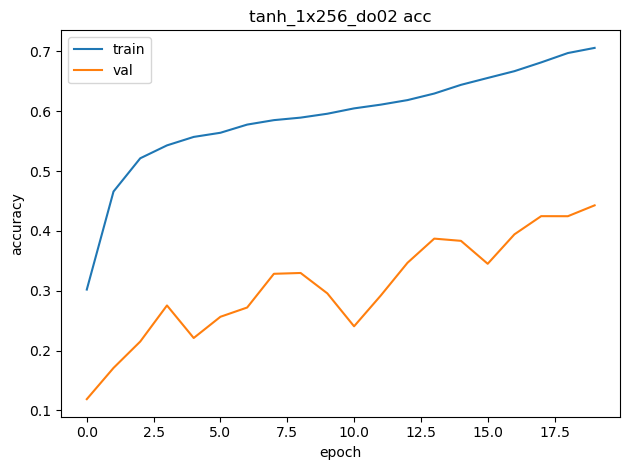

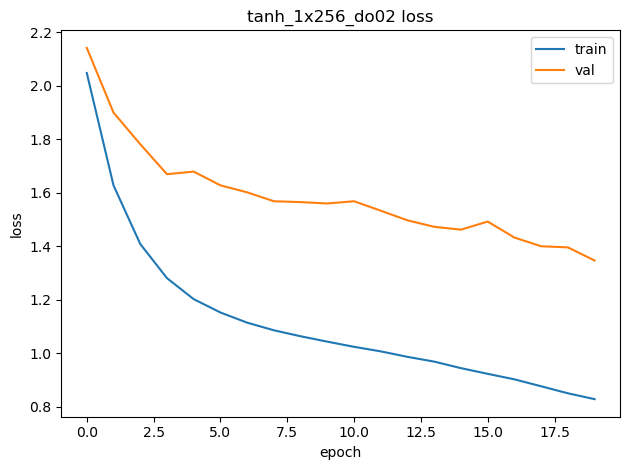

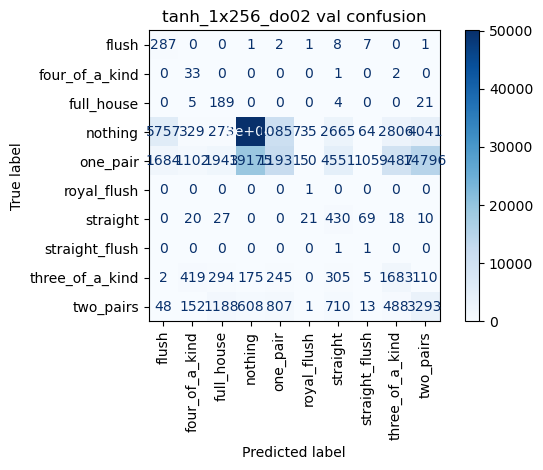

[10/14] tanh_2x256_do02
Epoch 1/20
20/20 [==============================] - 1s 23ms/step - loss: 1.7871 - accuracy: 0.3835 - val_loss: 1.7901 - val_accuracy: 0.2726
Epoch 2/20
20/20 [==============================] - 1s 29ms/step - loss: 1.2932 - accuracy: 0.5264 - val_loss: 1.6838 - val_accuracy: 0.2344
Epoch 3/20
20/20 [==============================] - 0s 10ms/step - loss: 1.1487 - accuracy: 0.5567 - val_loss: 1.5710 - val_accuracy: 0.3751
Epoch 4/20
20/20 [==============================] - 0s 12ms/step - loss: 1.0887 - accuracy: 0.5816 - val_loss: 1.5169 - val_accuracy: 0.4163
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 1.0305 - accuracy: 0.6036 - val_loss: 1.4987 - val_accuracy: 0.3937
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.9772 - accuracy: 0.6387 - val_loss: 1.3890 - val_accuracy: 0.4444
Epoch 7/20
20/20 [==============================] - 0s 10ms/step - loss: 0.9161 - accuracy: 0.6680 - val_loss: 1.3709 - val_accuracy

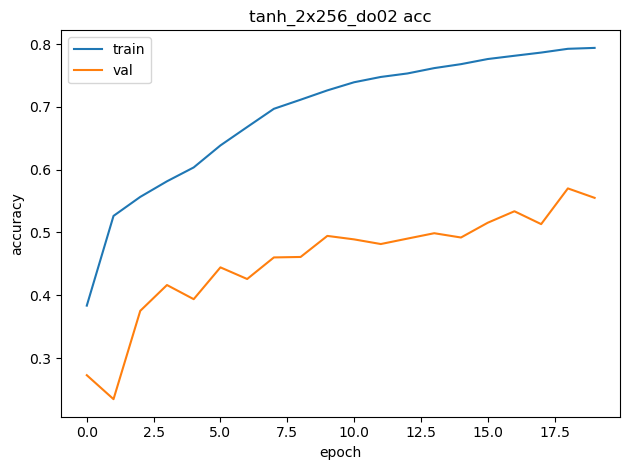

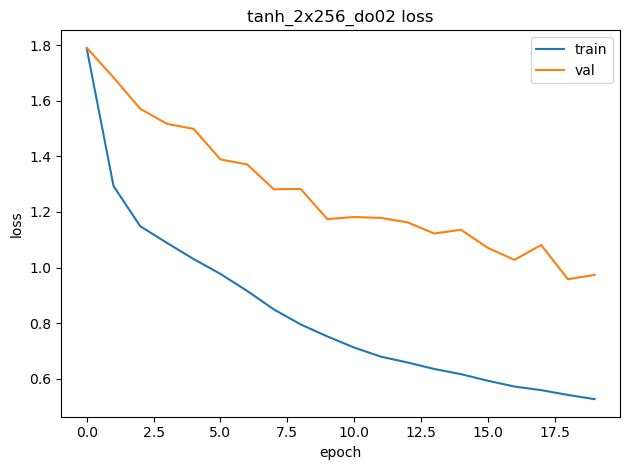

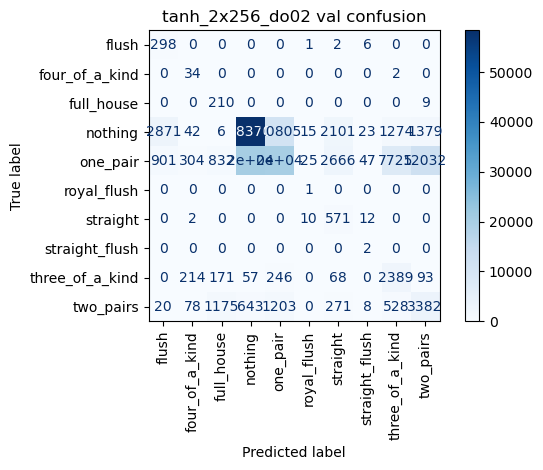

[11/14] sigmoid_1x128_do0
Epoch 1/20
20/20 [==============================] - 1s 18ms/step - loss: 2.2818 - accuracy: 0.1634 - val_loss: 2.3108 - val_accuracy: 0.0290
Epoch 2/20
20/20 [==============================] - 0s 21ms/step - loss: 2.1548 - accuracy: 0.3248 - val_loss: 2.2745 - val_accuracy: 0.0572
Epoch 3/20
20/20 [==============================] - 0s 8ms/step - loss: 2.0479 - accuracy: 0.3864 - val_loss: 2.1557 - val_accuracy: 0.2288
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 1.9458 - accuracy: 0.4097 - val_loss: 2.2024 - val_accuracy: 0.1035
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 1.8495 - accuracy: 0.4349 - val_loss: 2.1273 - val_accuracy: 0.1930
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 1.7603 - accuracy: 0.4621 - val_loss: 2.0533 - val_accuracy: 0.2136
Epoch 7/20
20/20 [==============================] - 0s 14ms/step - loss: 1.6780 - accuracy: 0.4728 - val_loss: 1.9661 - val_accuracy

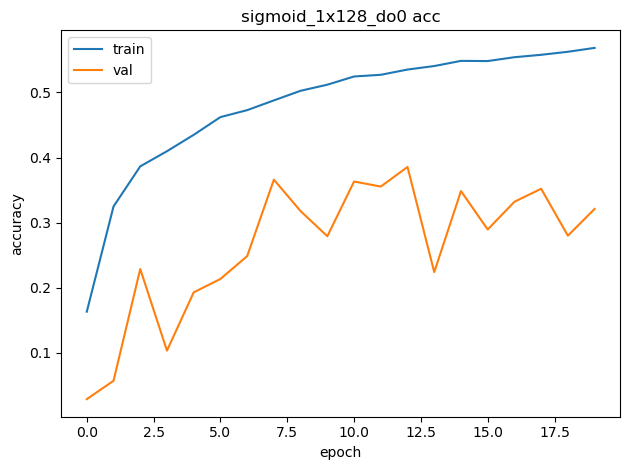

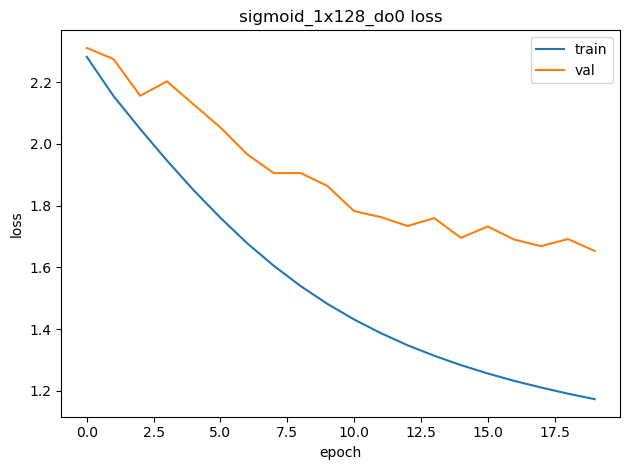

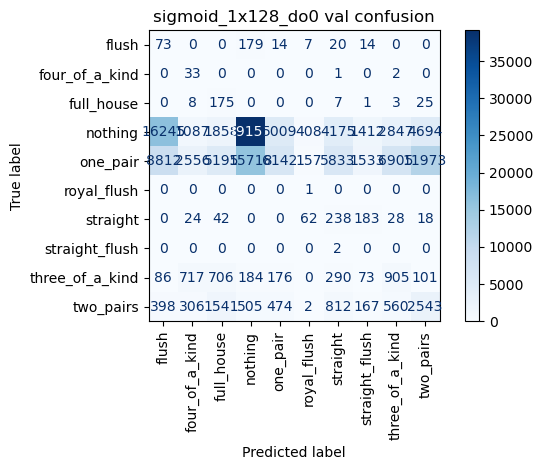

[12/14] sigmoid_2x128_do0
Epoch 1/20
20/20 [==============================] - 1s 19ms/step - loss: 2.3191 - accuracy: 0.1311 - val_loss: 2.3597 - val_accuracy: 0.0356
Epoch 2/20
20/20 [==============================] - 0s 23ms/step - loss: 2.2577 - accuracy: 0.2491 - val_loss: 2.3025 - val_accuracy: 0.3176
Epoch 3/20
20/20 [==============================] - 0s 13ms/step - loss: 2.1947 - accuracy: 0.3493 - val_loss: 2.2800 - val_accuracy: 0.2972
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 2.0932 - accuracy: 0.3604 - val_loss: 2.2123 - val_accuracy: 0.0246
Epoch 5/20
20/20 [==============================] - 0s 11ms/step - loss: 1.9675 - accuracy: 0.3821 - val_loss: 2.2006 - val_accuracy: 0.0036
Epoch 6/20
20/20 [==============================] - 0s 10ms/step - loss: 1.8442 - accuracy: 0.4065 - val_loss: 2.0942 - val_accuracy: 0.0040
Epoch 7/20
20/20 [==============================] - 0s 10ms/step - loss: 1.7258 - accuracy: 0.4286 - val_loss: 1.9968 - val_accur

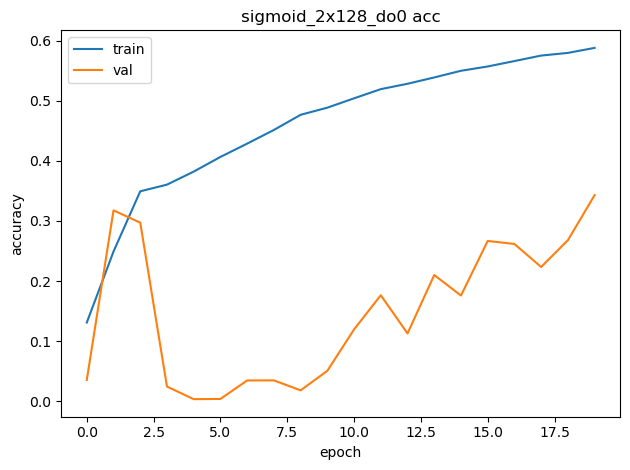

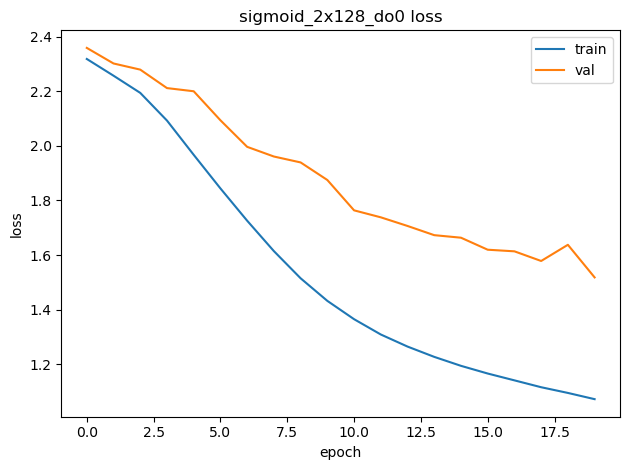

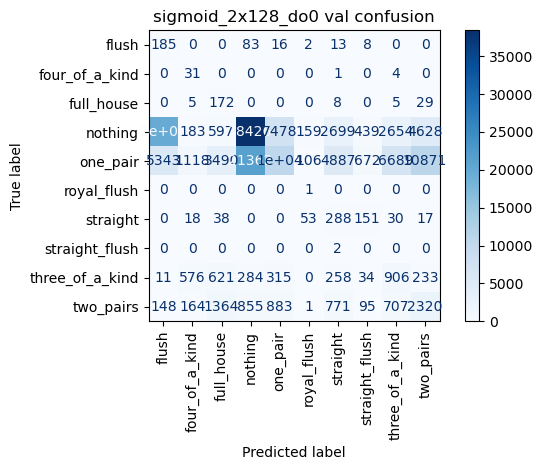

[13/14] sigmoid_1x256_do02
Epoch 1/20
20/20 [==============================] - 1s 20ms/step - loss: 2.3557 - accuracy: 0.1300 - val_loss: 2.2796 - val_accuracy: 0.0130
Epoch 2/20
20/20 [==============================] - 1s 26ms/step - loss: 2.1644 - accuracy: 0.2399 - val_loss: 2.2516 - val_accuracy: 0.0514
Epoch 3/20
20/20 [==============================] - 0s 12ms/step - loss: 2.0351 - accuracy: 0.3090 - val_loss: 2.1946 - val_accuracy: 0.0985
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 1.9190 - accuracy: 0.3593 - val_loss: 2.1080 - val_accuracy: 0.2517
Epoch 5/20
20/20 [==============================] - 0s 8ms/step - loss: 1.8208 - accuracy: 0.3975 - val_loss: 2.0462 - val_accuracy: 0.2726
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 1.7309 - accuracy: 0.4187 - val_loss: 1.9744 - val_accuracy: 0.2890
Epoch 7/20
20/20 [==============================] - 0s 8ms/step - loss: 1.6549 - accuracy: 0.4439 - val_loss: 1.9369 - val_accurac

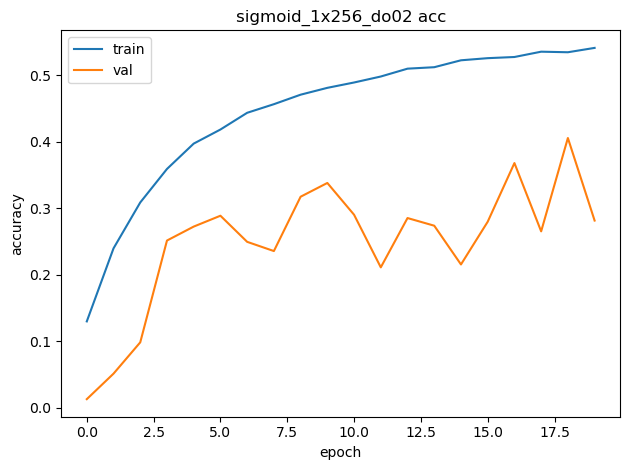

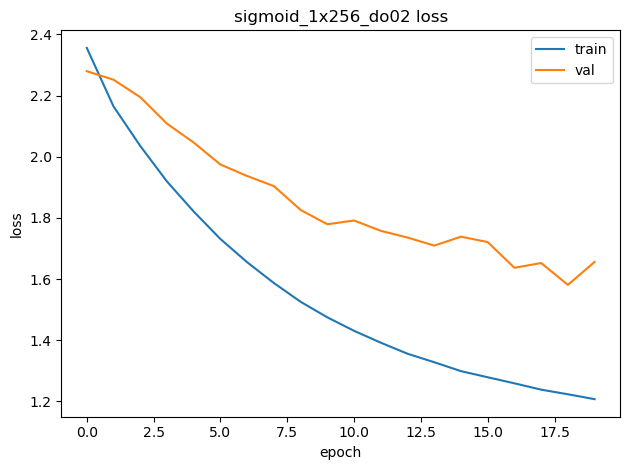

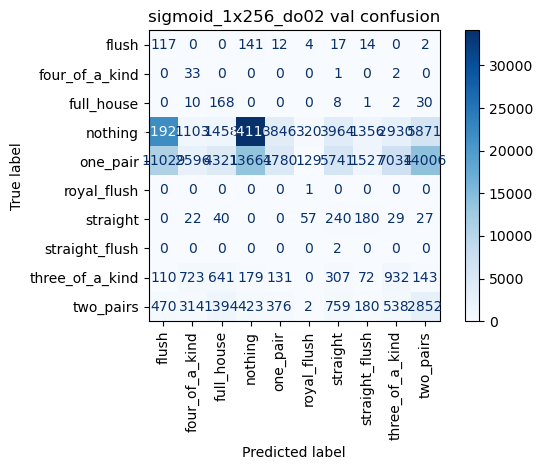

[14/14] sigmoid_2x256_do03
Epoch 1/20
20/20 [==============================] - 1s 18ms/step - loss: 2.4119 - accuracy: 0.1071 - val_loss: 2.3320 - val_accuracy: 0.0020
Epoch 2/20
20/20 [==============================] - 1s 31ms/step - loss: 2.3058 - accuracy: 0.1368 - val_loss: 2.3298 - val_accuracy: 0.0169
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 2.2219 - accuracy: 0.1996 - val_loss: 2.2788 - val_accuracy: 0.0517
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 2.1075 - accuracy: 0.2508 - val_loss: 2.1999 - val_accuracy: 0.1492
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 1.9772 - accuracy: 0.3011 - val_loss: 2.1328 - val_accuracy: 0.2598
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 1.8513 - accuracy: 0.3429 - val_loss: 2.0208 - val_accuracy: 0.3607
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 1.7336 - accuracy: 0.3762 - val_loss: 2.0592 - val_accuracy

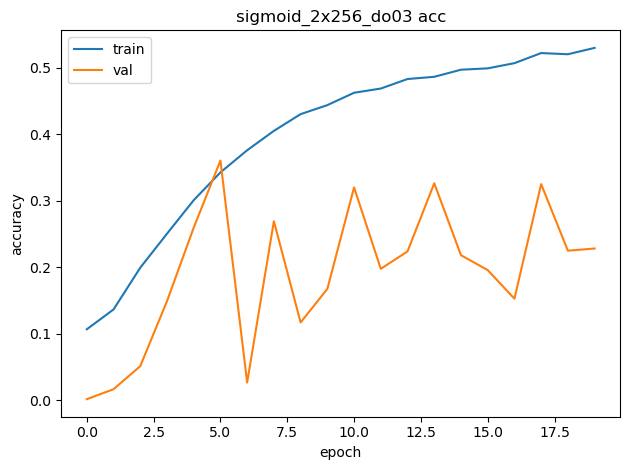

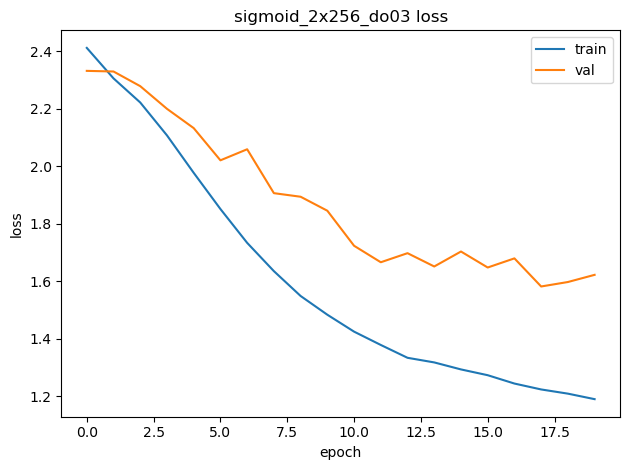

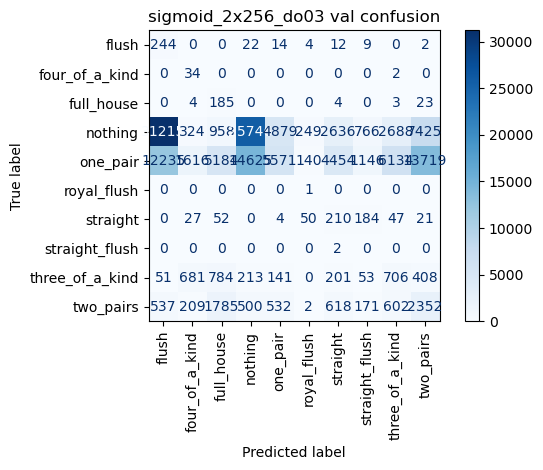

best by macro f1 relu_3x256_do03 0.7772762280361474


In [17]:
best_name = None
best_metric = -1.0
results = []
histories = {}          # store curves for combined plots
confusions = {}         # store cm arrays for later display

EPOCHS = 20

for i, cfg in enumerate(configs, 1):
    print(f'[{i}/{len(configs)}] {cfg["name"]}')
    model = build_model(X_train.shape[1], cfg, num_classes)
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )

    histories[cfg['name']] = {
        'act': cfg['act'],
        'val_accuracy': hist.history.get('val_accuracy', []),
        'val_loss': hist.history.get('val_loss', []),
        'train_accuracy': hist.history.get('accuracy', []),
        'train_loss': hist.history.get('loss', [])
    }

    # per run plots show and save
    acc_path  = f"../artifacts/experiments/{cfg['name']}_acc.png"
    loss_path = f"../artifacts/experiments/{cfg['name']}_loss.png"
    plt.figure(); plt.plot(hist.history['accuracy']); plt.plot(hist.history['val_accuracy']); plt.legend(['train','val']); plt.title(cfg['name']+' acc'); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.tight_layout(); plt.savefig(acc_path, dpi=150); plt.show()
    plt.figure(); plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']); plt.legend(['train','val']); plt.title(cfg['name']+' loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.tight_layout(); plt.savefig(loss_path, dpi=150); plt.show()

    # val metrics
    yv_pred = model.predict(X_val, batch_size=4096, verbose=0).argmax(1)
    macro_f1 = f1_score(y_val, yv_pred, average='macro')
    val_acc  = float(np.mean(yv_pred == y_val))

    # confusion matrix save and keep for end
    cm = confusion_matrix(y_val, yv_pred)
    confusions[cfg['name']] = cm
    disp = ConfusionMatrixDisplay(cm, display_labels=meta['label_classes'])
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title(cfg['name']+' val confusion')
    plt.tight_layout()
    plt.savefig(f"../artifacts/experiments/{cfg['name']}_val_confusion.png", dpi=150)
    plt.show()

    # classification report
    rep = classification_report(y_val, yv_pred, target_names=meta['label_classes'])
    with open(f"../artifacts/experiments/{cfg['name']}_val_report.txt",'w') as f: f.write(rep)

    results.append({'name':cfg['name'],'layers':cfg['layers'],'act':cfg['act'],'dropout':cfg['dropout'],'val_acc':val_acc,'macro_f1':float(macro_f1)})

    if macro_f1 > best_metric:
        best_metric = macro_f1
        best_name = cfg['name']
        model.save('../artifacts/best_so_far.keras')
        with open('../artifacts/best_so_far_name.txt','w') as f: f.write(best_name)

# save summary json
with open('../artifacts/experiments/results.json','w') as f:
    json.dump(results, f, indent=2)

print('best by macro f1', best_name, best_metric)


## Combined plots per activation
show and save combined validation curves per activation group

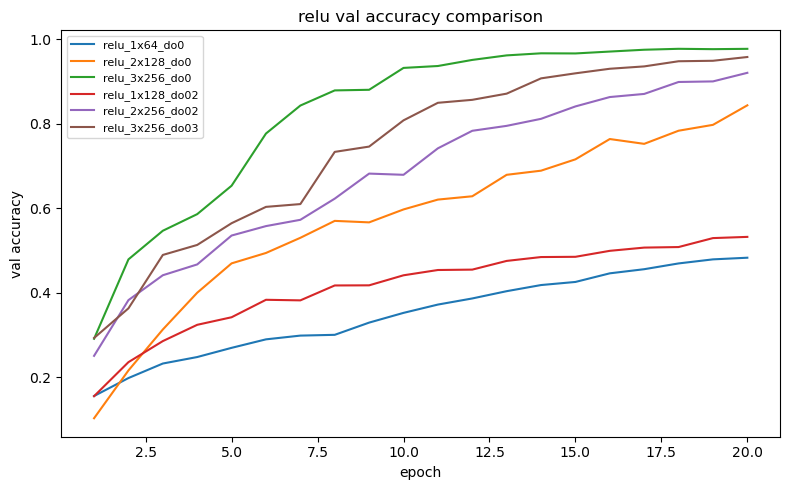

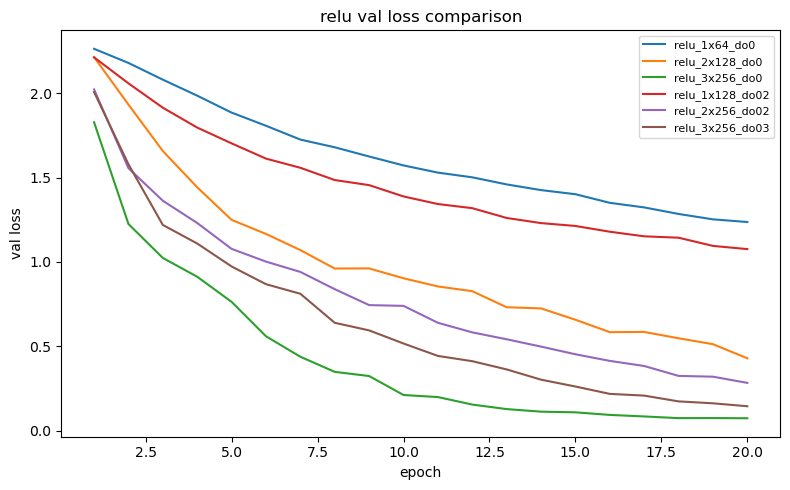

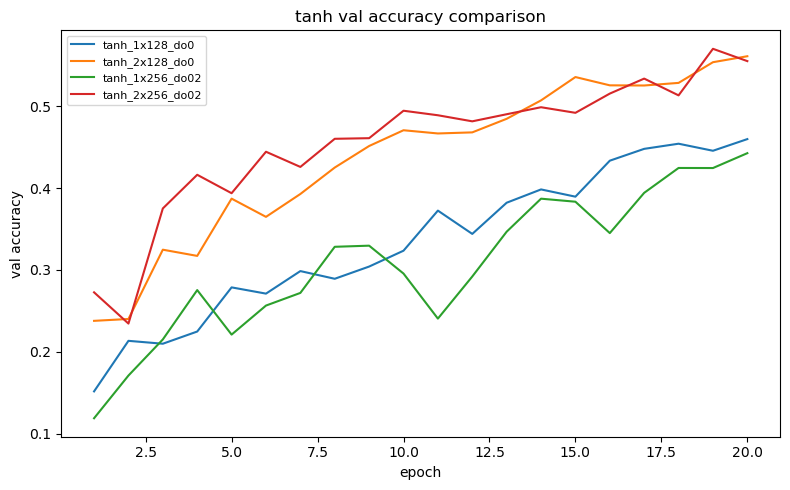

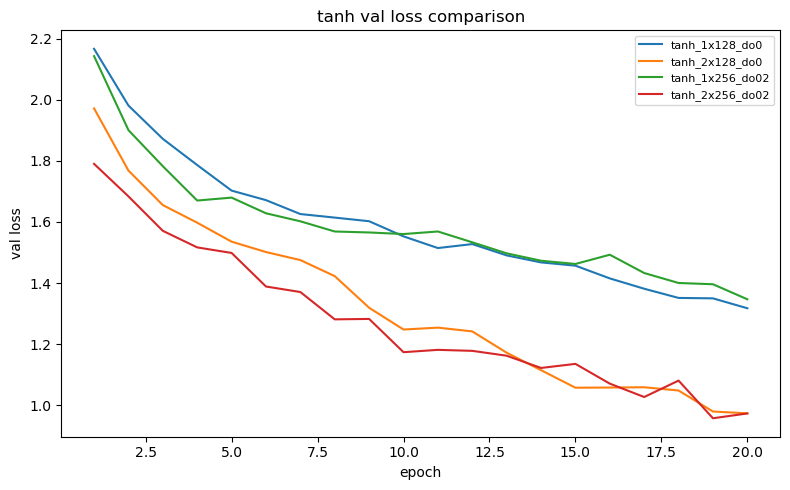

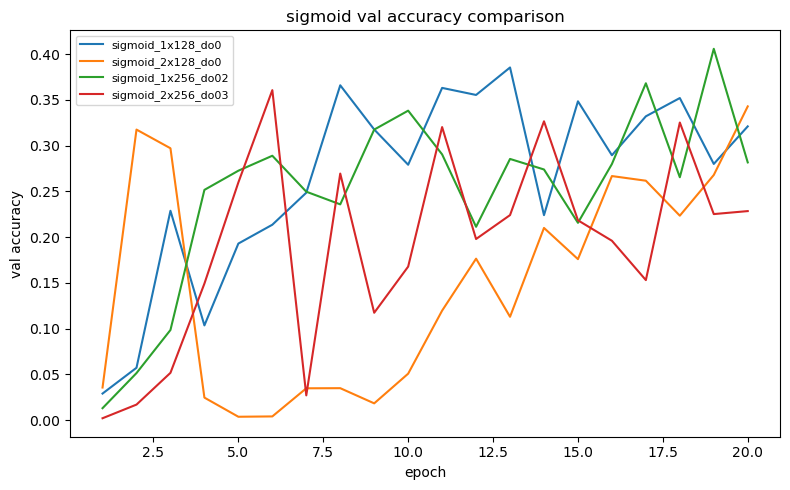

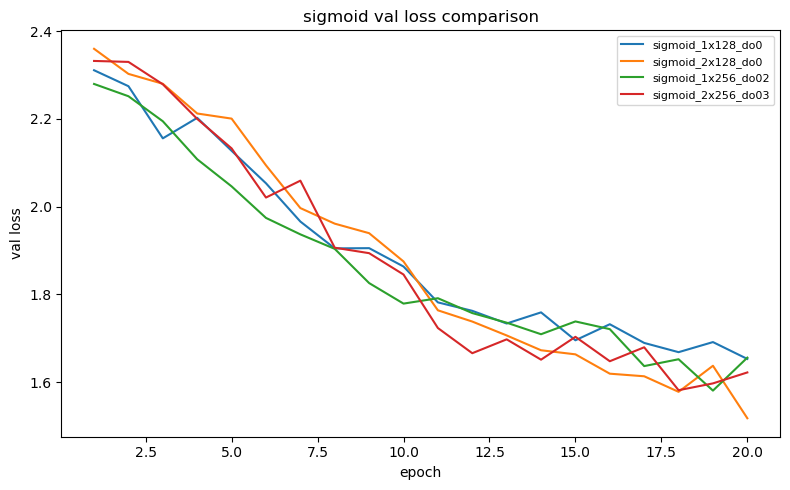

In [18]:
# group names by activation
by_act = {}
for name, h in histories.items():
    act = h['act']
    by_act.setdefault(act, []).append(name)

# make combined plots for each activation
for act, names in by_act.items():
    # val accuracy
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_accuracy']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title(f'{act} val accuracy comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_accuracy_{act}.png', dpi=150)
    plt.show()

    # val loss
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_loss']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title(f'{act} val loss comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_loss_{act}.png', dpi=150)
    plt.show()


## Overall combined plots
compare top models by macro f1

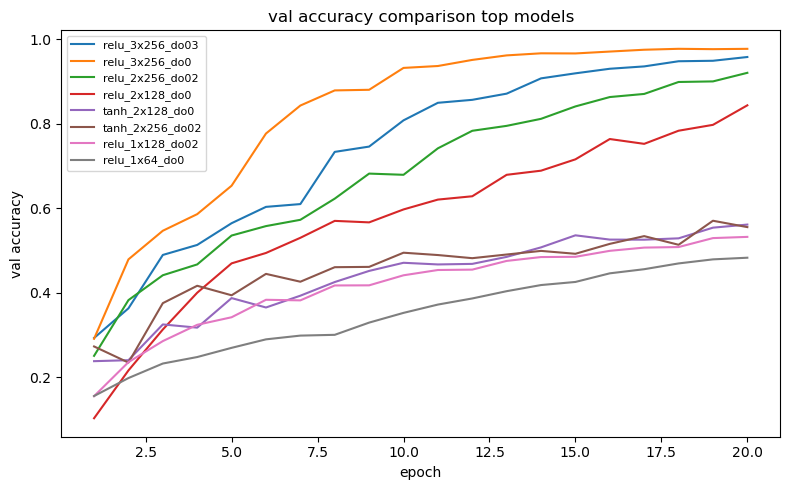

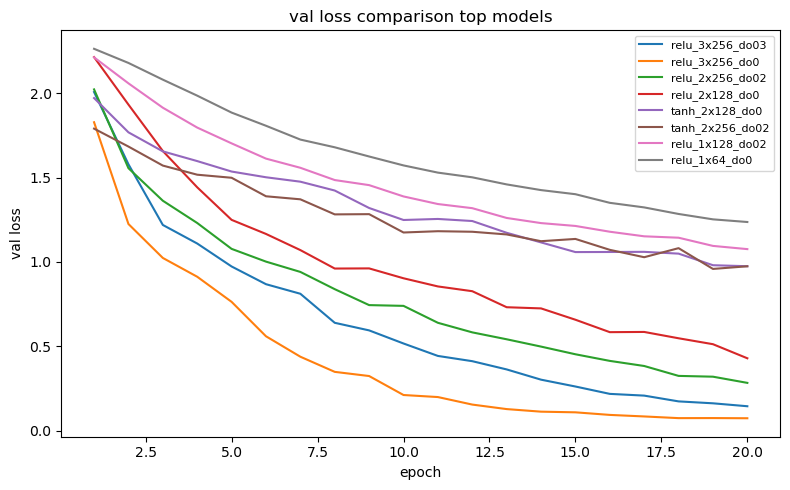

In [19]:
names_sorted = [r['name'] for r in sorted(results, key=lambda x: x['macro_f1'], reverse=True)]
top_names = names_sorted[:8]

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_accuracy']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title('val accuracy comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_accuracy_top.png', dpi=150)
plt.show()

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_loss']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title('val loss comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_loss_top.png', dpi=150)
plt.show()


## Visualize results json
show bar charts of val accuracy and macro f1 sorted by macro f1

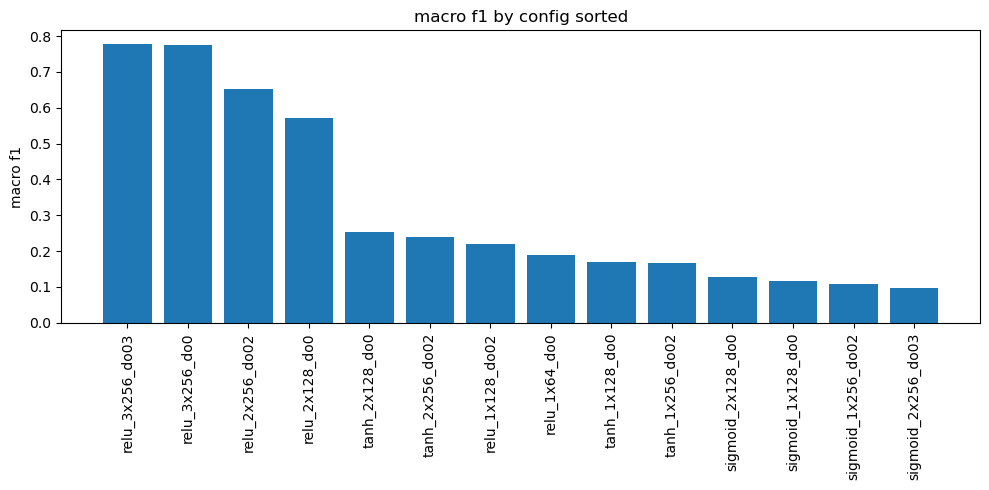

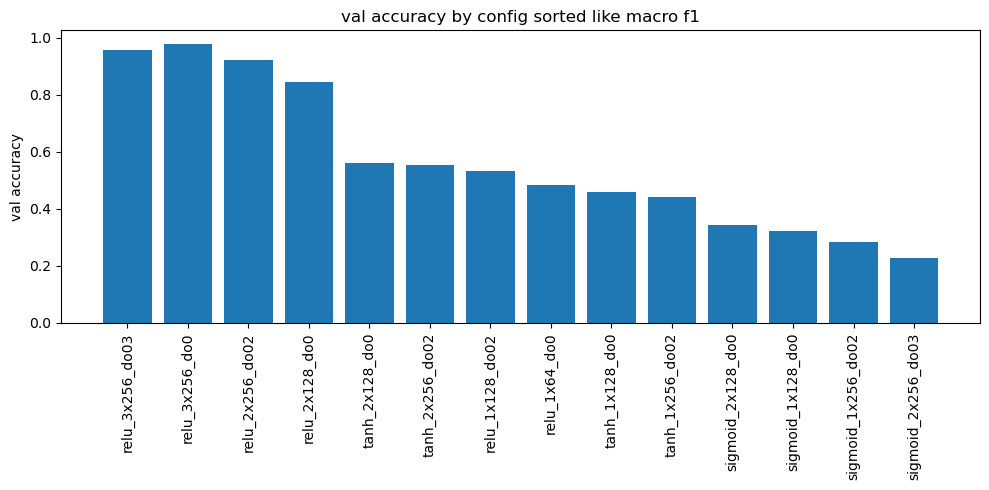

In [20]:
# ensure results is loaded if this cell runs alone
if 'results' not in globals():
    with open('../artifacts/experiments/results.json') as f:
        results = json.load(f)

# sort by macro f1
results_sorted = sorted(results, key=lambda x: x['macro_f1'], reverse=True)
names = [r['name'] for r in results_sorted]
val_accs = [r['val_acc'] for r in results_sorted]
macro_f1s = [r['macro_f1'] for r in results_sorted]

# macro f1 bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), macro_f1s)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('macro f1'); plt.title('macro f1 by config sorted')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_macro_f1.png', dpi=150)
plt.show()

# val acc bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), val_accs)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('val accuracy'); plt.title('val accuracy by config sorted like macro f1')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_val_acc.png', dpi=150)
plt.show()
